In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
remove = ('headers', 'footers', 'quotes')
print("Loading 20 newsgroups dataset for categories:")
data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=None,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

Loading 20 newsgroups dataset for categories:
data loaded


In [3]:
from pprint import pprint
pprint(list(data_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [4]:
data_train.filenames.shape

(11314,)

In [5]:
data_train.target.shape

(11314,)

In [6]:
data_train.target[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [7]:
#Escolhendo um conjunto menor para exemplificar
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

In [8]:
remove = ('headers', 'footers', 'quotes')
print("Loading 20 newsgroups dataset for categories:")
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

Loading 20 newsgroups dataset for categories:
data loaded


In [9]:
target_names = data_train.target_names

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

2034 documents - 2.428MB (training set)
1353 documents - 1.800MB (test set)
4 categories



In [10]:
# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)
feature_names = vectorizer.get_feature_names()

In [11]:
if feature_names:
    feature_names = np.asarray(feature_names)

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [12]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [13]:
results = []
for clf, name in (
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))
    
# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
train time: 0.004s
test time:  0.092s
accuracy:   0.248
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.24      0.32      0.27       319
     comp.graphics       0.29      0.27      0.28       389
         sci.space       0.29      0.17      0.21       394
talk.religion.misc       0.19      0.25      0.21       251

       avg / total       0.26      0.25      0.25      1353

confusion matrix:
[[101  87  58  73]
 [127 106  64  92]
 [120 107  66 101]
 [ 77  69  43  62]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dep

train time: 0.156s
test time:  0.000s
accuracy:   0.745
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.67      0.58      0.62       319
     comp.graphics       0.86      0.87      0.87       389
         sci.space       0.74      0.87      0.80       394
talk.religion.misc       0.64      0.56      0.60       251

       avg / total       0.74      0.75      0.74      1353

confusion matrix:
[[185  13  53  68]
 [  9 340  35   5]
 [ 17  29 342   6]
 [ 64  14  32 141]]



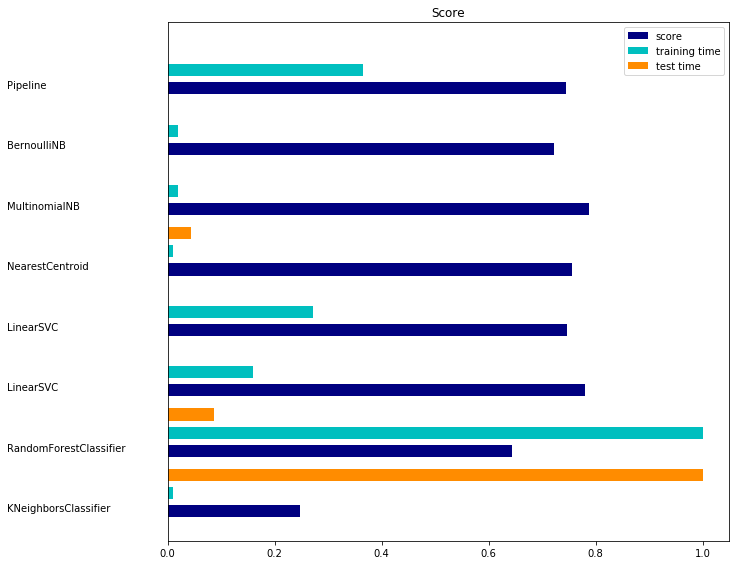

In [14]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()